# DoorDash Interview Regression Project

In [1]:
# Import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [2]:
# Import Data.
df = pd.read_csv('historical_data.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

# Feature Engineering

* Creating dependant variable.
* Creating 3 useful predictor variables.
* One hot encoding 3 categorical variables. 

In [4]:
# Convert date columns to datetime format.
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

In [5]:
# Create variable for the total duration of the order. This is our dependant variable.
df['total_duration'] = df['actual_delivery_time'] - df['created_at']

# Change the total_duration column to display the total secounds.
df['total_duration'] = df['total_duration'].apply(lambda x: x.total_seconds())

In [6]:
# Create variable for the ratio of busy dashers to onshift dashers.
df['ratio_busy_dashers'] = df['total_busy_dashers']/df['total_onshift_dashers']

In [7]:
# Create a variable for the total estimated time an order is not being prepared.
df['estimated_non_prep_duration'] = df['estimated_store_to_consumer_driving_duration'] + df['estimated_order_place_duration']

store_primary_category has a lot of missing values and we will fill them using the most common value for each store, with store_id being the reference variable. 

In [8]:
# Create a reference dictionary with the most frequent categories of each store.
store_id_unique = df['store_id'].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode()
                         for store_id in store_id_unique}

In [9]:
# Define function 'fill' to return the primary_store_category value from the dictionary.
def fill(store_id):
    """Return primary store category from the dictionary"""
    try: 
        return store_id_and_category[store_id].values[0]
    except: 
        return np.NaN
    
# Apply our fill function to fill the nan values into a new variable.  
df["nan_free_store_primary_category"] = df.store_id.apply(fill)

In [10]:
# Check the number of unique values in each of the categorical variables.
print('Number of unique values in market_id:', df['market_id'].nunique())
print('Number of unique values in order_protocol:', df['order_protocol'].nunique())
print('Number of unique values in store_id:', df['store_id'].nunique())
print('Number of unique values in nan_free_store_primary_category:', df['nan_free_store_primary_category'].nunique())

Number of unique values in market_id: 6
Number of unique values in order_protocol: 7
Number of unique values in store_id: 6743
Number of unique values in nan_free_store_primary_category: 74


We will one hot encode the market_id, order_protocol and nan_free_store_primary_category variables as they have a small amount of unique values.

In [11]:
# Create dummy variables for market_id.
market_id_dummies = pd.get_dummies(df.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')

# Create dummy variables for order_protocol.
order_protocol_dummies = pd.get_dummies(df.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')

# Create dummy variables for nan_free_store_primary_category.
store_primary_category_dummies = pd.get_dummies(df.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')

In [12]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_duration,ratio_busy_dashers,estimated_non_prep_duration,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0,indian


# Data Preprocessing

* Drop unnecessary features.
* Concat dummy variables to our training dataset.
* Align data types across the whole dataset.
* Drop infinite values.

In [13]:
# Drop unnecessary features from the training dataset.
train_df = df.drop(columns = ['created_at', 'market_id', 'store_id', 'order_protocol', 'store_primary_category', 
                              'actual_delivery_time', 'nan_free_store_primary_category'])

In [14]:
# Concat dummy variables to our training dataset.
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)

In [15]:
# Align data types across the whole dataset.
train_df = train_df.astype('float32')

In [16]:
# Drop infinite values.
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

In [17]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Removing Collinear Features

* Create correlation matrix to look for outliers.
* Define two functions that will help us find the pairs of features with the highest correlation values.
* Feature engineer and drop redundant features to eliminate collineararity from our dataset.

In [18]:
# Create a mask for our correlation matrix.
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

<Axes: >

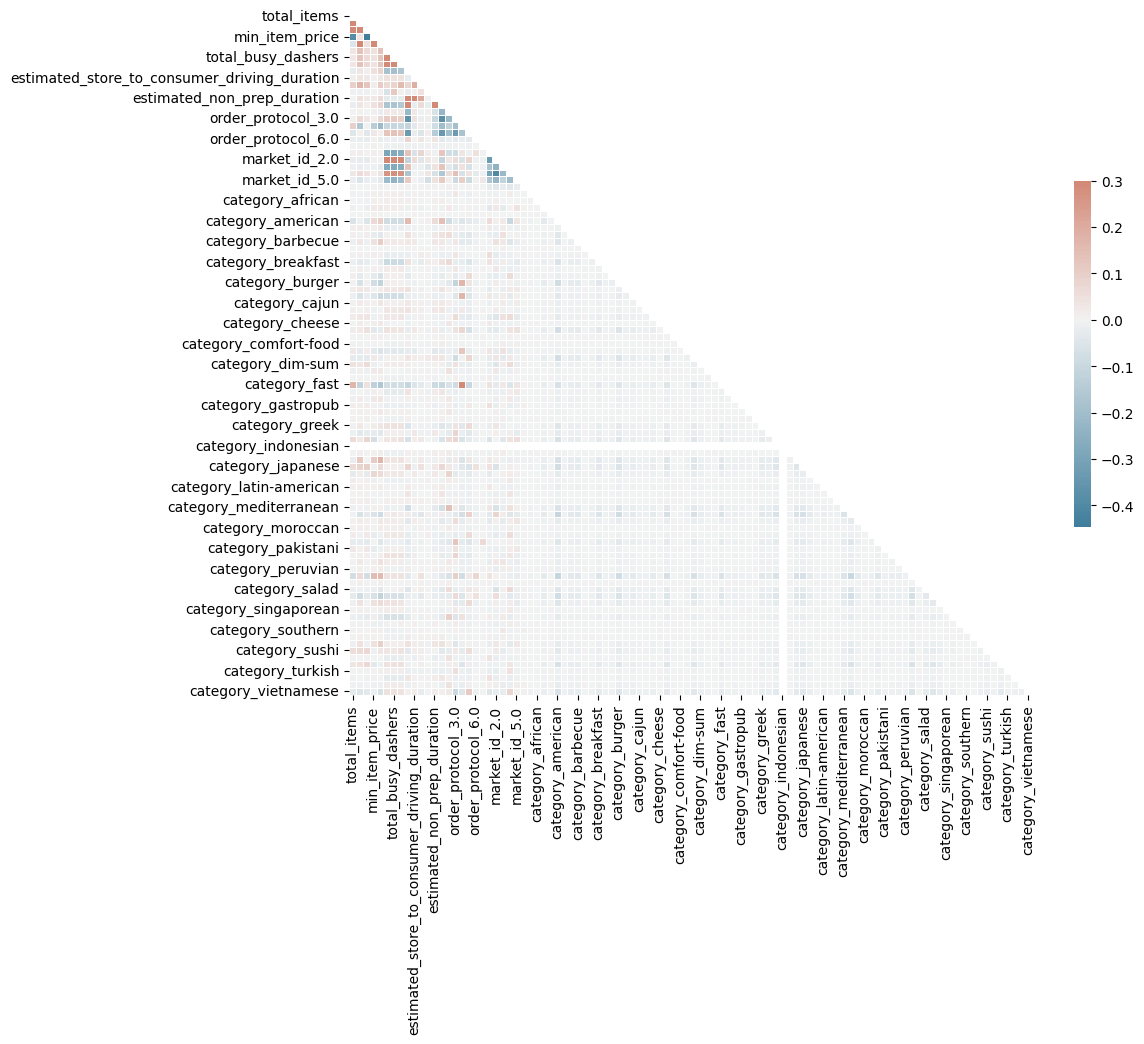

In [19]:
# Set up matplotlib figure.
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colourmap.
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct the aspect ratio.
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5})

In [20]:
# Upon observation of the correaltion matrix we can see that category_indonesian 
# has all 0 values and so we will drop it.
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [21]:
# Define a function to get redunant pairs of features from the dataset.
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df. columns
    for i in range(0, df.shape[1]): 
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j])) 
    return pairs_to_drop

In [22]:
# Define a fucntion that returns the highest correlation values of pairs of features in the dataset.
def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [23]:
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

* Both total_onshift_dashers and total_busy_dashers appear to be reduntant as they have high correlation values and as they are represented by the ratio_busy_dashers feature that we created earlier so we can drop these two features.
* estimated_store_to_consumer_driving_duration and estimated_non_prep_duration are highly correlated with each other and as we created estimated_non_prep_duration we can drop that feature as well.
* market_id appears to show consistently significant correlations as well so we will not concat it to our dataset.

In [24]:
# Drop unnecessary features from the training dataset.
train_df = df.drop(columns = ['created_at', 'market_id', 'store_id', 'order_protocol', 'store_primary_category', 
                              'actual_delivery_time', 'nan_free_store_primary_category'])

In [25]:
# Don't concat market id.
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

In [26]:
# Drop highly correlated features.
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers',
                                  'category_indonesian', 
                                  'estimated_non_prep_duration'])

# Align dtype over dataset.
train_df = train_df.astype("float32")

# Replace inf values with nan to drop all nans.
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_duration,ratio_busy_dashers,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

* order_protocol show consistently high correlation values so we will not concat it to our dataset.

In [28]:
# Drop unnecessary features from the training dataset.
train_df = df.drop(columns = ['created_at', 'market_id', 'store_id', 'order_protocol', 'store_primary_category', 
                              'actual_delivery_time', 'nan_free_store_primary_category'])

In [29]:
# Don't concat order protool.
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)

In [30]:
# drop highly correlated features
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers',
                                  'category_indonesian', 
                                  'estimated_non_prep_duration'])

# align dtype over dataset
train_df = train_df.astype("float32")

# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

train_df.head()

print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  total_duration                    0.188418
subtotal                                      total_duration                    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

* total_items, num_distinct_items and subtotal are all highly correlated with each other. To deal with this we will create two new features by combining our correlated features together and then dropping num_distinct_items and subtotal.

In [31]:
# New features.
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items']/train_df['total_items']
train_df['avg_price_per_item'] = train_df['subtotal']/train_df['total_items']
# Drop redundant features.
train_df.drop(columns=['num_distinct_items', 'subtotal'], inplace=True)
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  total_duration                    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

* Now min_item_price and max_item_price are showing high correlation values with each other and also other features. To solve this problem we will combine these two features together into one feature and then drop them from the dataset.

In [32]:
# New feature.
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']
# Drop redundant  features.
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  total_duration                    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      total_duration                    0.15

In [33]:
train_df

,total_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_duration,ratio_busy_dashers,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,...,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese,percent_distinct_item_of_total,avg_price_per_item,price_range_of_items
0,4.0,21.0,446.0,861.0,3779.0,0.424242,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,860.250000,682.0
1,1.0,2.0,446.0,690.0,4024.0,2.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1900.000000,0.0
2,1.0,0.0,446.0,690.0,1781.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1900.000000,0.0
3,6.0,2.0,446.0,289.0,3075.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,1150.000000,1200.0
4,3.0,9.0,446.0,650.0,2390.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1300.000000,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,3.0,23.0,251.0,331.0,3907.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,463.000000,304.0
197424,6.0,14.0,251.0,915.0,3383.0,0.916667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,501.666656,420.0
197425,5.0,40.0,251.0,795.0,3008.0,1.051282,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,367.200012,99.0
197426,1.0,12.0,446.0,384.0,3907.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1175.000000,0.0


The correlations between our features appear to have dropped significantly due to dropping redundant features and also feature engineering and we have reduced our data frame to 82 features.

# Reducing Multicolinearity

* Define a function that computes the vif score for each of the features and sorts them in order.
* Use a while loop to drop all features with a vif score greater than 20.

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [35]:
# Define a function to compute the vif score for each of the features and sort them in order.
def compute_vif(features):
    """Compute VIF score using variance variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [36]:
# Apply function to our dataset.
features = train_df.drop(columns=['total_duration']).columns.to_list()
vif_data =  compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000373
1,category_chocolate,1.000508
2,category_belgian,1.000771
3,category_russian,1.003245
4,category_african,1.003825
...,...,...
76,ratio_busy_dashers,6.369577
77,category_american,7.033606
78,estimated_store_to_consumer_driving_duration,7.210893
79,estimated_order_place_duration,13.470942


* We are going to drop all features that have a vif score greater than 20 in order to reduce multicollinearity in our dataset.

In [37]:
# Use a while loop to drop all features with a vif score greater than 20.
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print('I will remove', highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data
    

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000224
1,category_chocolate,1.000377
2,category_belgian,1.000472
3,category_russian,1.002037
4,category_gluten-free,1.002381
...,...,...
75,category_american,4.505930
76,avg_price_per_item,5.958989
77,ratio_busy_dashers,6.357856
78,estimated_store_to_consumer_driving_duration,7.192701


# Feature Selection

* Use RandomForestRegressor to find the Gini importance of all the features in the dataset.
* Use PCA to find the optimum number of features to represent our dataset.

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [39]:
# Train-test split dataset.
X = train_df[selected_features]
y = train_df['total_duration']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

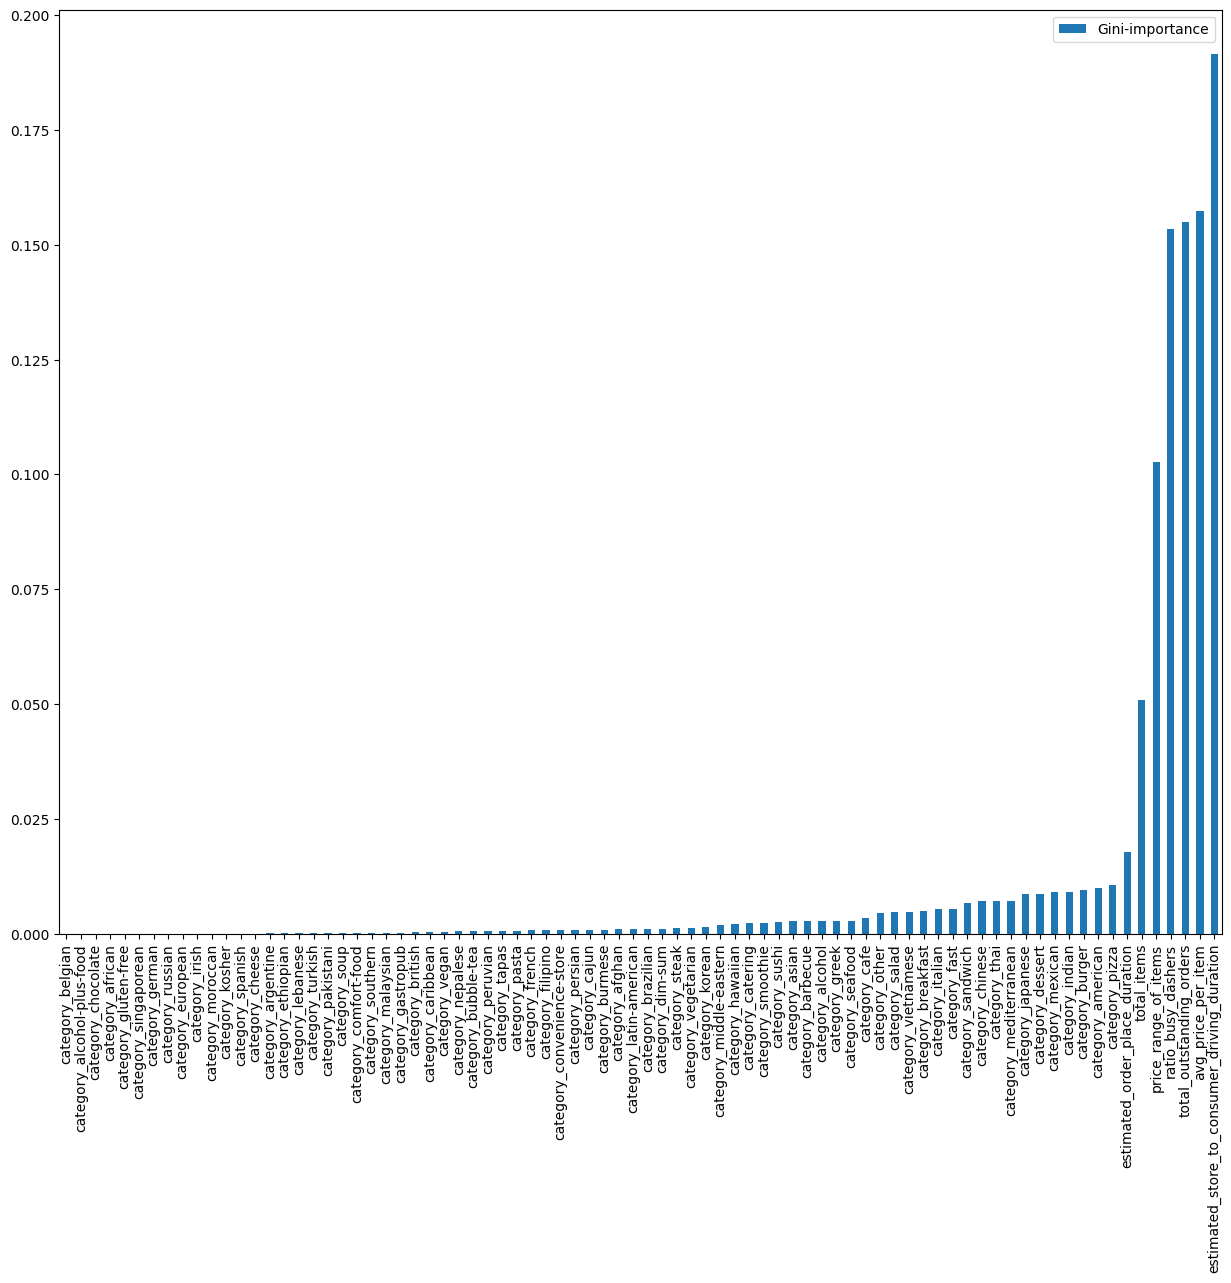

In [40]:
# Apply RandomForestRegressor and find Gini importance of our features. 
feature_names = [f"feature P{i}" for i in range((X.shape[1]))] # Save feature names.
forest = RandomForestRegressor(random_state=42) # Define and fit RandomeForestRegressor.
forest.fit(X_train, y_train)
feats = {} # A dict to hold feature_name: feature_importance.
for feature, importance in zip(X.columns, forest.feature_importances_): # Match features with their importance.
    feats[feature] = importance # Add the name/value pair.
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'}) # Sort freatures by their importance.
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15, 12)) # Plot feature importances.
plt.show()

<ipython-input-41-e57f02a01352>:12: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


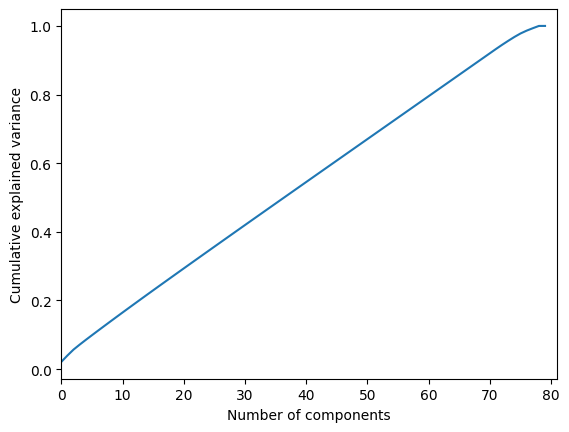

In [41]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train.
X_std=StandardScaler().fit_transform(X_Train)
# Fit PCA to our dataset.
pca = PCA().fit(X_std) 
# Generate a plot to show the cumulative explained variance of the principal components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show ()

# Scaling

* Define a function to apply different scalars to our data.

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [43]:
# Define a scalar for X and y.
def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [44]:
# Example to test the function.
X_scaled, y_scaled, X_scaler, Y_scaler = scale(MinMaxScaler(), X, y)

# Train test slpit after scaling.
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
X_scaled, y_scaled, test_size=0.2, random_state=42)

In [45]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # Return RMSE with squared False.
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    
    return rmse_error, y_predict

# Model Building

* Find the optimum regression model, feature size and scalar by comparing the RMSE scores.
* Feature engineer a new dependant variable to see if we can decrease the RMSE score.
* Use the predicitons of our new dependant variable as an independant variable in a new regresion model that will the predict the total_duration.

Apply 6 different regression algorithims:
* Ridge Regression
* Decision Tree Regressor
* Random Forrest Regressor
* XGBoost Regressor
* LGM Regressor
* MLP Regressor

Select 4 different feature set sizes selected by Gini's importance:
* Full feature set
* 40 selected features 
* 20 selected features
* 10 selected features

Apply 3 different scalars:
* Standard scalar
* Min-Max scalar
* No scalar

In [49]:
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from sklearn.neural_network import MLPRegressor 
from sklearn import tree 
from sklearn import svm 
from sklearn import neighbors 
from sklearn import linear_model

In [51]:
# Create a generic function which can work with multiple machine learning models.
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error""" 
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print ("Train error - "'{}'.format(train_error)+" in " + model_name)
        print("Test error"'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    return trained_model, y_predict, train_error, test_error

In [52]:
# Create dictionaries for each of our parameters.
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}

regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "GBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

feature_sets = {
    "full dataset": X.columns. to_list(),
    "selected_features_40": importances. sort_values(by= 'Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by= 'Gini-importance')[-20:].index.tolist(),
    "selected_ _features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(),
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

In [56]:
# Compute the Root Mean Squared Error for each combination of different models, feature sizes and scalars.
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers. keys():
        print(f"------scaled with {scaler_name}------ included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["total_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42) 
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name) 
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------scaled with Standard scaler------ included columns are full dataset

Train error - 0.767963171005249 in Ridge
Test error1.4719302654266357 in Ridge
Error = 2053.69873046875 in Ridge
Train error - 0.7653021361303404 in DecisionTree
Test error1.4744739559914226 in DecisionTree
Error = 2057.2476687088733 in DecisionTree
Train error - 0.28666217119919196 in RandomForest
Test error1.4672312183652763 in RandomForest
Error = 2047.1422982076203 in RandomForest
Train error - 0.6924042105674744 in GBoost
Test error1.4594244956970215 in GBoost
Error = 2036.2498779296875 in GBoost
Train error - 0.7297768813103676 in LGBM
Test error1.4574073174711764 in LGBM
Error = 2033.4355809987908 in LGBM
Train error - 0.7389032244682312 in MLP
Test error1.4607653617858887 in MLP
Error = 2038.12109375 in MLP
------scaled with MinMax scaler------ included columns are full dataset

Train error - 0.0032242187298834324 in Ridge
Test error0.006179544143378735 in Ridge
Error = 2053.962890625 in Ridge
Train erro

/Users/kaaneyvaz/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.4253e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error - 1067.7815291116704 in DecisionTree
Test error2057.2476684096064 in DecisionTree
Train error - 396.1697159906428 in RandomForest
Test error2047.6414162500841 in RandomForest
Train error - 968.2471313476562 in GBoost
Test error2036.43212890625 in GBoost
Train error - 1017.5549840201221 in LGBM
Test error2034.461097275308 in LGBM
Train error - 1054.5858154296875 in MLP
Test error2047.3568115234375 in MLP
------scaled with Standard scaler------ included columns are selected_features_40

Train error - 0.7685800194740295 in Ridge
Test error1.47214937210083 in Ridge
Error = 2054.00439453125 in Ridge
Train error - 0.7653050277966773 in DecisionTree
Test error1.4739590156893994 in DecisionTree
Error = 2056.5292024696128 in DecisionTree
Train error - 0.28593693191637654 in RandomForest
Test error1.4675824239891306 in RandomForest
Error = 2047.6323149574548 in RandomForest
Train error - 0.6926604509353638 in GBoost
Test error1.4588536024093628 in GBoost
Error = 2035.453369140625 in 

/Users/kaaneyvaz/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error - 1067.785563647774 in DecisionTree
Test error2056.529202224364 in DecisionTree
Train error - 396.81476109112884 in RandomForest
Test error2048.793061700262 in RandomForest
Train error - 965.6858520507812 in GBoost
Test error2035.7642822265625 in GBoost
Train error - 1017.1430421117441 in LGBM
Test error2034.8058530174258 in LGBM


/Users/kaaneyvaz/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error - 1059.757568359375 in MLP
Test error2050.584716796875 in MLP
------scaled with Standard scaler------ included columns are selected_features_20

Train error - 0.770122230052948 in Ridge
Test error1.4731249809265137 in Ridge
Error = 2055.36572265625 in Ridge
Train error - 0.7662722630951128 in DecisionTree
Test error1.4725837048094073 in DecisionTree
Error = 2054.610311207463 in DecisionTree
Train error - 0.28350494171940377 in RandomForest
Test error1.4685613983302512 in RandomForest
Error = 2048.998220861293 in RandomForest
Train error - 0.6905712485313416 in GBoost
Test error1.4604161977767944 in GBoost
Error = 2037.6336669921875 in GBoost
Train error - 0.7301559207008418 in LGBM
Test error1.4592620523768804 in LGBM
Error = 2036.0233846729805 in LGBM
Train error - 0.7417997717857361 in MLP
Test error1.460108995437622 in MLP
Error = 2037.205078125 in MLP
------scaled with MinMax scaler------ included columns are selected_features_20

Train error - 0.0032332856208086014 in 

/Users/kaaneyvaz/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.43857e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error - 1069.1350906055598 in DecisionTree
Test error2054.610311170708 in DecisionTree
Train error - 397.61665803849627 in RandomForest
Test error2048.749498414466 in RandomForest
Train error - 966.1651000976562 in GBoost
Test error2036.249267578125 in GBoost
Train error - 1018.9600610110249 in LGBM
Test error2035.9494403356318 in LGBM


/Users/kaaneyvaz/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error - 1062.031494140625 in MLP
Test error2052.0595703125 in MLP
------scaled with Standard scaler------ included columns are selected_ _features_10

Train error - 0.7717142105102539 in Ridge
Test error1.4739872217178345 in Ridge
Error = 2056.568359375 in Ridge
Train error - 0.7663420076820632 in DecisionTree
Test error1.4725742906448305 in DecisionTree
Error = 2054.5971761770547 in DecisionTree
Train error - 0.2866093525006613 in RandomForest
Test error1.4702464570554377 in RandomForest
Error = 2051.349285279795 in RandomForest
Train error - 0.6992177963256836 in GBoost
Test error1.4623059034347534 in GBoost
Error = 2040.27001953125 in GBoost
Train error - 0.7331284482493243 in LGBM
Test error1.4607728842307477 in LGBM
Error = 2038.1313604554389 in LGBM
Train error - 0.746978223323822 in MLP
Test error1.4623433351516724 in MLP
Error = 2040.3226318359375 in MLP
------scaled with MinMax scaler------ included columns are selected_ _features_10

Train error - 0.003239990910515189 i

In [82]:
# Put all of the models and their RMSE scores in a dataset.
pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2053.69873
1,DecisionTree,full dataset,Standard scaler,2057.247669
2,RandomForest,full dataset,Standard scaler,2049.375921
3,GBoost,full dataset,Standard scaler,2036.249878
4,LGBM,full dataset,Standard scaler,2033.435581
...,...,...,...,...
87,GBoost,selected_features_40,Standard scaler,2037.820312
88,LGBM,selected_features_40,Standard scaler,2035.723637
89,MLP,selected_features_40,Standard scaler,2037.855469
90,LGBM,selected_features_40,Standard scaler,2035.723637


In [66]:
# Plot the RMSE scores.
px.bar(pred_df, y='RMSE', color='feature_set', barmode='group')

* The models appear to have a high error rate.
* The specific scalar used does not seem to impact model performance.
* The decrease in training feature size first slightly improves the performance and then marginally made it worse.

Moving forward we will

* Use only the standard scalar.
* Use a feature size of 40.
* Change our dependant variable to preperation time and then add our prediction to the estimated_store_to_consumer_driving_duration and estimated_order_place_duration to find the total_diuration.

In [67]:
# Change the dependant variable to the preperation time.
train_df["prep_time"] = train_df["total_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

# The specific scalar used does not impact the model perfomance. We will use the standard scalar.
scalers = {
    "Standard scaler": StandardScaler(),
}
# Use the 40 most important features by Gini importance.
feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

# Compute the Root Mean Squared Error for all the models with a feature size of 40 and the standard scalar. 
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            # Drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration.
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # To get indices.
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # Scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # Apply indexing.
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)
        

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2055.40771484375 in Ridge
Error = 2045.9600605629953 in DecisionTree
Error = 2046.905540283222 in RandomForest
Error = 2037.8203125 in GBoost
Error = 2035.7236370573405 in LGBM
Error = 2037.85546875 in MLP


LGM preforms the best out of all the models so we will use it to make our predictions.

In [68]:
# The specific scalar used does not impact the model perfomance. We will use the standard scalar.
scalers = {
    "Standard scaler": StandardScaler(),
}

# Use the 40 most important features by Gini importance.
feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

# Use only LGM
regression_models = {
    "LGBM": LGBMRegressor(),
}

# Compute the Root Mean Squared Error for the LGM model with a feature size of 40 and the standard scalar. 
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            # Drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration.
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # To get indices.
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # Scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # Apply indexing.
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2035.7236370573405 in LGBM


In [70]:
# Choose best performing model and extract the predictions for preparation duration.
pred_values_dict = {
    "total_duration": train_df["total_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),
}             

In [71]:
# Convert predictions to a dataframe from dict.
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,total_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [72]:
# Sum predictions with non preparation activities such as order placing and driving.
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

,total_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [74]:
# Check new error rate.
mean_squared_error(values_df["total_duration"], values_df["sum_total_delivery_duration"], squared=False)

2035.7236370573405

The RMSE is still large so we will now use another regresion to obtain the actual total delivery duration using preparation duration prediction, estimated store-to-consumer driving duration, and order place duration

In [76]:
# Train test split our features.
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["total_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Define a dictionary with all of the regression models we want to use.
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
# Use for loop and make_regression function to get the RMSE of all the different models.
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

RMSE of: LinearReg 986.6912510303843
RMSE of: Ridge 986.6912510344929
RMSE of: DecisionTree 1235.578088153976
RMSE of: RandomForest 1229.765929451028
RMSE of: XGBoost 1370.412425918564
RMSE of: LGBM 1079.2949179771774
RMSE of: MLP 987.0169352315239


This approach has halved the error rate of our models and there for is our solution.

# Deep Learning

The MLP performance was not better than the tree based regressions when predicting the preperation duration, which would suggest that Artificial Neural Networks wont preform better than our classical machine learning models. However the MLP did preform relatively well when predicting the total_duration so we will try out an ANN.

In [78]:
# Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

# Neural network.
def create_model(feature_set_size):
    
    # Define the model.
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # Compile the model.
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [80]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["total_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
443/443 [==============================] - 3s 5ms/step - loss: 1.1366 - root_mean_squared_error: 1.0661
Epoch 2/100
443/443 [==============================] - 2s 4ms/step - loss: 1.1195 - root_mean_squared_error: 1.0581
Epoch 3/100
443/443 [==============================] - 2s 5ms/step - loss: 1.1186 - root_mean_squared_error: 1.0576
Epoch 4/100
443/443 [==============================] - 2s 4ms/step - loss: 1.1185 - root_mean_squared_error: 1.0576
Epoch 5/100
443/443 [==============================] - 2s 4ms/step - loss: 1.1181 - root_mean_squared_error: 1.0574
Epoch 6/100
443/443 [==============================] - 2s 4ms/step - loss: 1.1182 - root_mean_squared_error: 1.0575
Epoch 7/100
443/443 [==============================] - 2s 4ms/step - loss: 1.1180 - root_mean_squared_error: 1.0574
Epoch 8/100
443/443 [==============================] - 2s 5ms/step - loss: 1.1179 - 

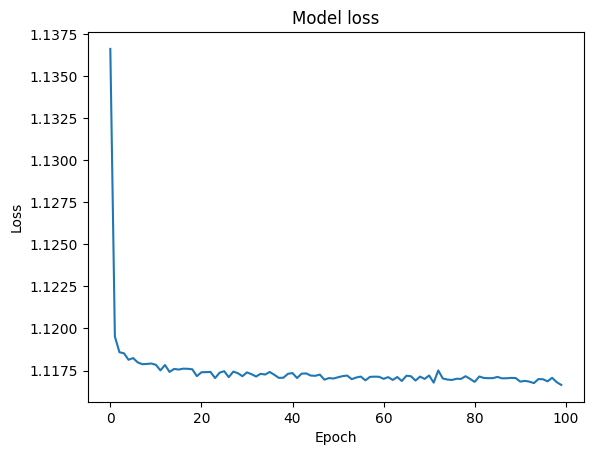

In [81]:
plt.plot(history.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()

We achieved the same performance with the MLP method from sklearn. It could be possible to improve the performance with hyperparameter tuning in the ANN, however, it would require a considerable amount time and effort. As we have a well performing Linear Regression model that is simple and fast we will use the LGBM + Linear Regression as our official solution.